In [5]:
import pandas as pd
import numpy as np
import joblib as jb
import seaborn as sns 
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SVMSMOTE
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [6]:
df=pd.read_csv('../csv_files/creditFraud.csv')
df.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0


In [7]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [8]:
fraud_data_count=df['isFraud'].value_counts()[0]

non_fraud_data=df[df['isFraud']==0] 
fraud_data=df[df['isFraud']==1]

non_fraud_reduced=non_fraud_data.sample(frac=(16000/fraud_data_count),random_state=1)

df_reduced=pd.concat([fraud_data,non_fraud_reduced]).drop(columns=['isFlaggedFraud','step'])

df_reduced['isFraud'].value_counts()

isFraud
0    16000
1     8213
Name: count, dtype: int64

In [9]:
df_reduced.describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,2.421300e+04,2.421300e+04,2.421300e+04,2.421300e+04,2.421300e+04,24213.000000
mean,6.208137e+05,1.106257e+06,6.269927e+05,9.086277e+05,1.247478e+06,0.339198
std,1.640453e+06,3.197880e+06,2.711397e+06,3.696411e+06,4.123993e+06,0.473447
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,2.394940e+04,7.120000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,1.323501e+05,5.683300e+04,0.000000e+00,0.000000e+00,1.518001e+05,0.000000
75%,3.599757e+05,4.940271e+05,2.442420e+04,6.349302e+05,1.067666e+06,1.000000
max,4.867221e+07,5.958504e+07,4.958504e+07,2.362305e+08,2.367265e+08,1.000000


In [10]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24213 entries, 2 to 2648588
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            24213 non-null  object 
 1   amount          24213 non-null  float64
 2   nameOrig        24213 non-null  object 
 3   oldbalanceOrg   24213 non-null  float64
 4   newbalanceOrig  24213 non-null  float64
 5   nameDest        24213 non-null  object 
 6   oldbalanceDest  24213 non-null  float64
 7   newbalanceDest  24213 non-null  float64
 8   isFraud         24213 non-null  int64  
dtypes: float64(5), int64(1), object(3)
memory usage: 1.8+ MB


In [11]:
df_reduced.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
2,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1
3,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1
251,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1
252,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1
680,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1


In [12]:
inputs=df_reduced.drop(columns='isFraud')
targets=df_reduced.isFraud

x_train,x_test,y_train,y_test=train_test_split(inputs,targets,test_size=.2,random_state=1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(19370, 8)
(19370,)
(4843, 8)
(4843,)


In [13]:
x_train.describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,1.937000e+04,1.937000e+04,1.937000e+04,1.937000e+04,1.937000e+04
mean,6.274084e+05,1.097893e+06,6.108514e+05,8.981757e+05,1.244461e+06
std,1.658545e+06,3.132310e+06,2.629002e+06,3.421295e+06,3.909240e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.379318e+04,6.665000e+02,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.315941e+05,5.732496e+04,0.000000e+00,0.000000e+00,1.515086e+05
75%,3.585705e+05,5.005577e+05,2.349953e+04,6.316607e+05,1.070345e+06
max,4.867221e+07,5.958504e+07,4.958504e+07,2.362305e+08,2.367265e+08


In [14]:
y_train.value_counts()

isFraud
0    12814
1     6556
Name: count, dtype: int64

In [15]:
x_train['type'].unique()

array(['PAYMENT', 'CASH_OUT', 'TRANSFER', 'CASH_IN', 'DEBIT'],
      dtype=object)

In [16]:
num_features=['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
cat_features=['type']

preprocessor=ColumnTransformer(
    [
        ('num',StandardScaler(),num_features),
        ('cat',OneHotEncoder(drop='first', handle_unknown='ignore'),cat_features)
    ],
    remainder='drop'
)


x_train_processed=pd.DataFrame(
    preprocessor.fit_transform(x_train),
    columns=preprocessor.get_feature_names_out()
)
x_test_processed=pd.DataFrame(
    preprocessor.transform(x_test),
    columns=preprocessor.get_feature_names_out()
)

print(x_train_processed.shape)
print(x_test_processed.shape)

(19370, 9)
(4843, 9)


In [17]:
preprocessor.named_transformers_['cat'].categories_

[array(['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER'],
       dtype=object)]

In [18]:
x_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   num__amount          19370 non-null  float64
 1   num__oldbalanceOrg   19370 non-null  float64
 2   num__newbalanceOrig  19370 non-null  float64
 3   num__oldbalanceDest  19370 non-null  float64
 4   num__newbalanceDest  19370 non-null  float64
 5   cat__type_CASH_OUT   19370 non-null  float64
 6   cat__type_DEBIT      19370 non-null  float64
 7   cat__type_PAYMENT    19370 non-null  float64
 8   cat__type_TRANSFER   19370 non-null  float64
dtypes: float64(9)
memory usage: 1.3 MB


In [19]:
x_train_processed.describe()

,num__amount,num__oldbalanceOrg,num__newbalanceOrig,num__oldbalanceDest,num__newbalanceDest,cat__type_CASH_OUT,cat__type_DEBIT,cat__type_PAYMENT,cat__type_TRANSFER
count,1.937000e+04,1.937000e+04,1.937000e+04,1.937000e+04,1.937000e+04,19370.000000,19370.000000,19370.000000,19370.000000
mean,-1.907497e-17,2.897929e-17,3.228072e-17,-3.081342e-17,-1.393940e-17,0.404130,0.004233,0.225142,0.220754
std,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,0.490736,0.064928,0.417687,0.414765
min,-3.782981e-01,-3.505150e-01,-2.323571e-01,-2.625318e-01,-3.183467e-01,0.000000,0.000000,0.000000,0.000000
25%,-3.639519e-01,-3.503022e-01,-2.323571e-01,-2.625318e-01,-3.183467e-01,0.000000,0.000000,0.000000,0.000000
50%,-2.989530e-01,-3.322133e-01,-2.323571e-01,-2.625318e-01,-2.795892e-01,0.000000,0.000000,0.000000,0.000000
75%,-1.620968e-01,-1.907062e-01,-2.234183e-01,-7.790087e-02,-4.454076e-02,1.000000,0.000000,0.000000,0.000000
max,2.896878e+01,1.867269e+01,1.862892e+01,6.878635e+01,6.023885e+01,1.000000,1.000000,1.000000,1.000000


# Checking distribution

- Amount distribution

/tmp/ipykernel_52/192893567.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels([fraud_labels[int(float(i.get_text()))] for i in plot.get_xticklabels()])


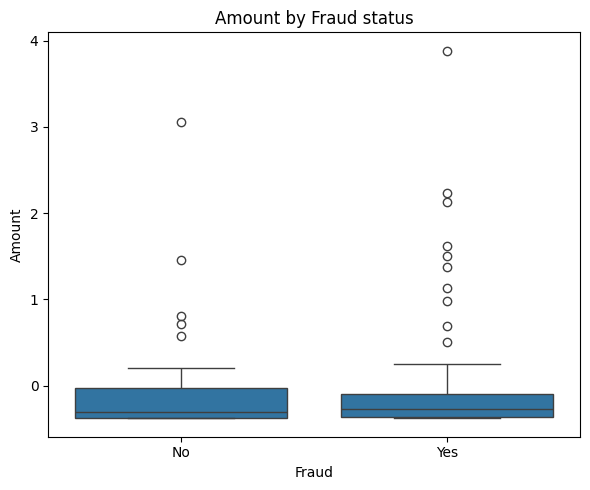

In [20]:
%matplotlib inline

fraud_labels={0:'No',1:'Yes'}

plt.figure(figsize=(6,5))
plot=sns.boxplot(y=x_train_processed['num__amount'],x=y_train)
plt.ylabel("Amount")
plt.xlabel("Fraud")
plt.title("Amount by Fraud status")
plot.set_xticklabels([fraud_labels[int(float(i.get_text()))] for i in plot.get_xticklabels()])

plt.tight_layout()
plt.show()

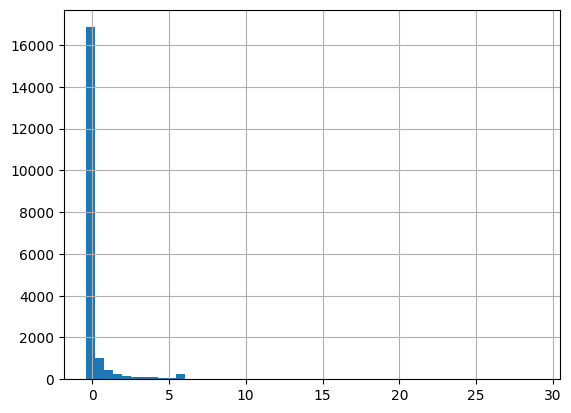

In [21]:
x_train_processed["num__amount"].hist(bins=50)
plt.show()

- oldbalanceOrg distribution

/tmp/ipykernel_52/960565132.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels([fraud_labels[int(float(i.get_text()))] for i in plot.get_xticklabels()])


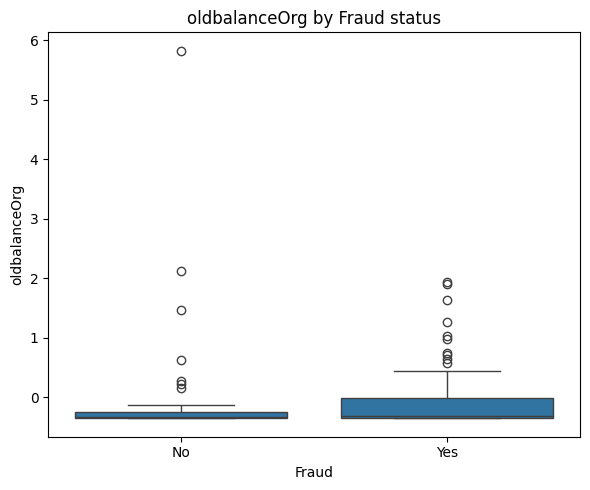

In [22]:
plt.figure(figsize=(6,5))
plot=sns.boxplot(y=x_train_processed['num__oldbalanceOrg'],x=y_train)
plt.ylabel("oldbalanceOrg")
plt.xlabel("Fraud")
plt.title("oldbalanceOrg by Fraud status")
plot.set_xticklabels([fraud_labels[int(float(i.get_text()))] for i in plot.get_xticklabels()])

plt.tight_layout()
plt.show()

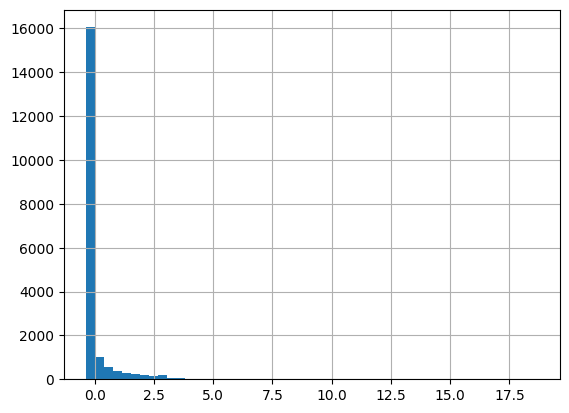

In [23]:
x_train_processed["num__oldbalanceOrg"].hist(bins=50)
plt.show()

- newbalanceOrig  distribution

/tmp/ipykernel_52/479674023.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels([fraud_labels[int(float(i.get_text()))] for i in plot.get_xticklabels()])


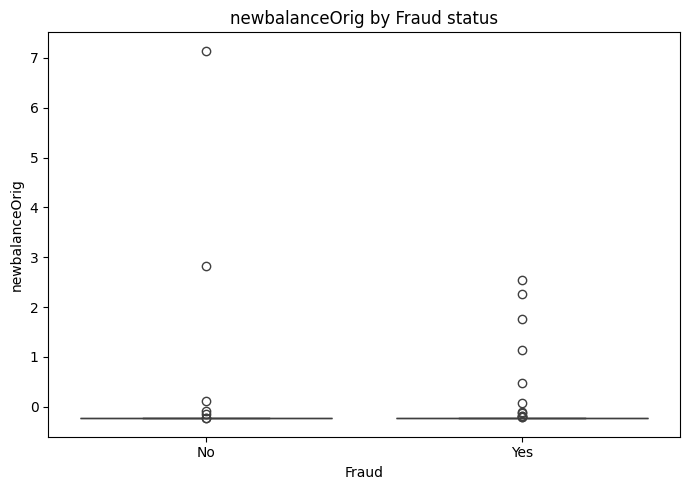

In [24]:
plt.figure(figsize=(7,5))
plot=sns.boxplot(y=x_train_processed['num__newbalanceOrig'],x=y_train)
plt.ylabel("newbalanceOrig")
plt.xlabel("Fraud")
plt.title("newbalanceOrig by Fraud status")
plot.set_xticklabels([fraud_labels[int(float(i.get_text()))] for i in plot.get_xticklabels()])

plt.tight_layout()
plt.show()

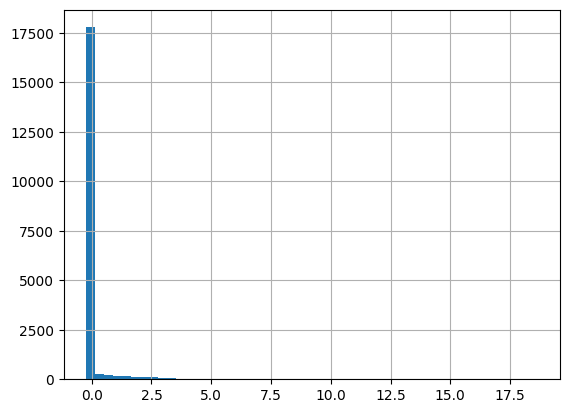

In [25]:
x_train_processed["num__newbalanceOrig"].hist(bins=50)
plt.show()

# Processing outliers

In [26]:
outliers_features=['num__amount','num__oldbalanceOrg','num__newbalanceOrig']

for feature in outliers_features:
    q1=x_train_processed[feature].quantile(.25)
    q3=x_train_processed[feature].quantile(.75)

    iqr=q3-q1

    lowest_bound=q1-2*iqr
    upper_bound=q3+2*iqr

    x_train_processed.loc[
        (x_train_processed[feature]>upper_bound) | (x_train_processed[feature]<lowest_bound),
        feature
    ]=x_train_processed[feature].median()

/tmp/ipykernel_52/1739195186.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(xticklabels)


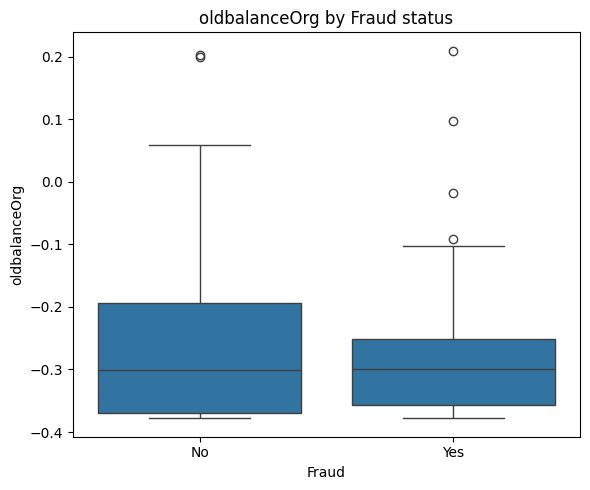

In [27]:
plt.figure(figsize=(6,5))
plot=sns.boxplot(y=x_train_processed['num__amount'],x=y_train)
plt.ylabel("oldbalanceOrg")
plt.xlabel("Fraud")
plt.title("oldbalanceOrg by Fraud status")
xticklabels=[fraud_labels[int(float(i.get_text()))] for i in plot.get_xticklabels()]
plot.set_xticklabels(xticklabels)

plt.tight_layout()
plt.show()

/tmp/ipykernel_52/960565132.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels([fraud_labels[int(float(i.get_text()))] for i in plot.get_xticklabels()])


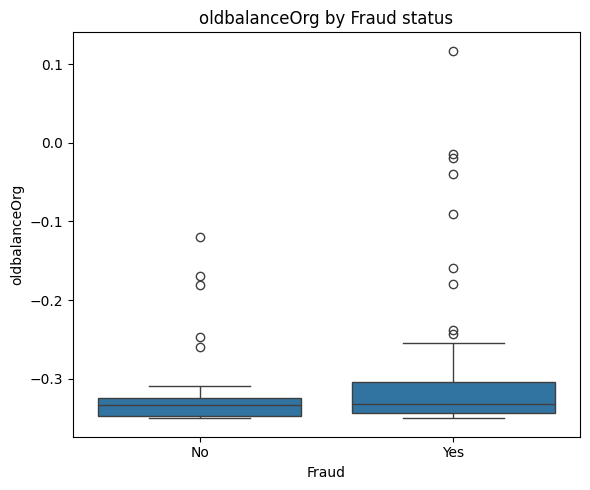

In [28]:
plt.figure(figsize=(6,5))
plot=sns.boxplot(y=x_train_processed['num__oldbalanceOrg'],x=y_train)
plt.ylabel("oldbalanceOrg")
plt.xlabel("Fraud")
plt.title("oldbalanceOrg by Fraud status")
plot.set_xticklabels([fraud_labels[int(float(i.get_text()))] for i in plot.get_xticklabels()])

plt.tight_layout()
plt.show()

/tmp/ipykernel_52/479674023.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels([fraud_labels[int(float(i.get_text()))] for i in plot.get_xticklabels()])


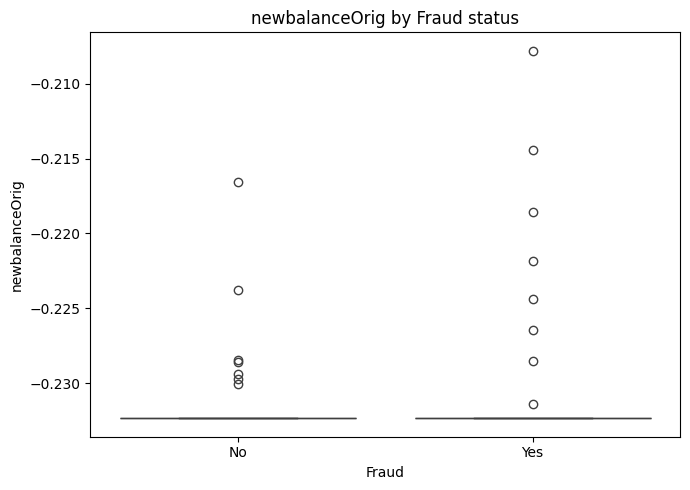

In [29]:
plt.figure(figsize=(7,5))
plot=sns.boxplot(y=x_train_processed['num__newbalanceOrig'],x=y_train)
plt.ylabel("newbalanceOrig")
plt.xlabel("Fraud")
plt.title("newbalanceOrig by Fraud status")
plot.set_xticklabels([fraud_labels[int(float(i.get_text()))] for i in plot.get_xticklabels()])

plt.tight_layout()
plt.show()

# Graphs

- Old destination balance / new destination balance

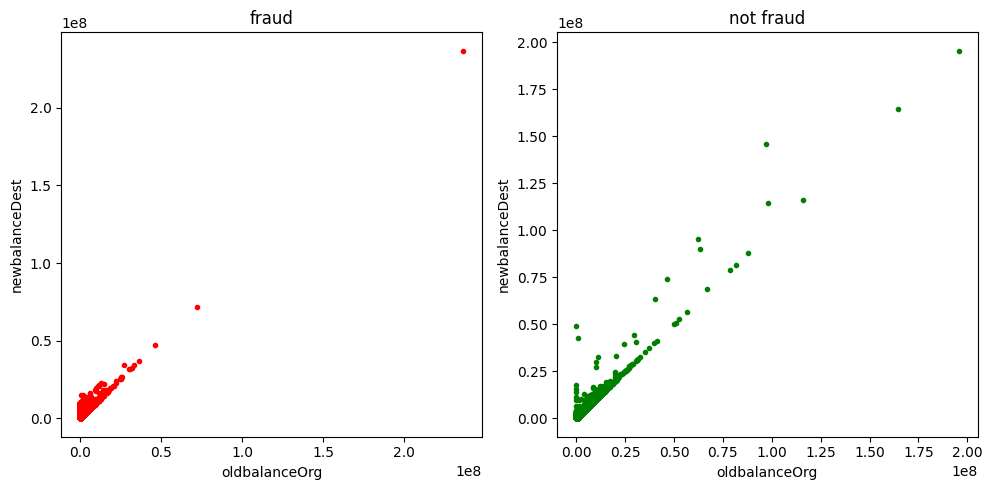

In [30]:
fraud_true_data=df_reduced[df_reduced['isFraud']==1]
fraud_false_data=df_reduced[df_reduced['isFraud']==0]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].scatter(fraud_true_data['oldbalanceDest'],fraud_true_data['newbalanceDest'],c='red',marker='.')
axes[0].set_title("fraud")
axes[0].set_xlabel("oldbalanceOrg")
axes[0].set_ylabel("newbalanceDest")

axes[1].scatter(fraud_false_data['oldbalanceDest'],fraud_false_data['newbalanceDest'],c='green',marker='.')
axes[1].set_title("not fraud")
axes[1].set_xlabel("oldbalanceOrg")
axes[1].set_ylabel("newbalanceDest")

plt.tight_layout()
plt.show()

- Pie graph to represent the percentage of each transaction type in fraudulant and non-fraudulant transactions

In [31]:
ftd_value_counts=fraud_true_data.type.value_counts()
ftd_labels=ftd_value_counts.index
ftd_sizes=ftd_value_counts.values
ftd_value_counts

type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64

In [32]:
ffd_value_counts=fraud_false_data.type.value_counts()
ffd_labels=ffd_value_counts.index
ffd_sizes=ffd_value_counts.values
ffd_value_counts

type
CASH_OUT    5681
PAYMENT     5373
CASH_IN     3564
TRANSFER    1279
DEBIT        103
Name: count, dtype: int64

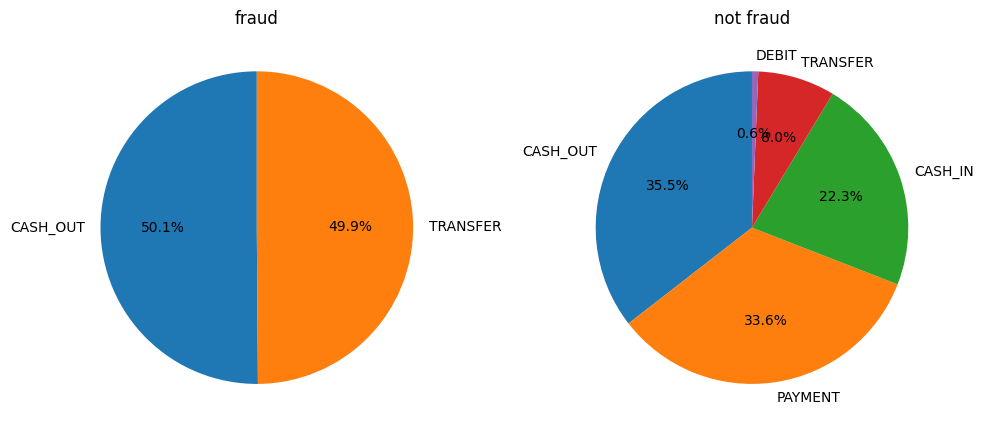

In [33]:
fig,axes=plt.subplots(1,2,figsize=(10,5))

axes[0].pie(ftd_sizes,labels=ftd_labels,autopct='%1.1f%%', startangle=90)
axes[0].set_title("fraud")

axes[1].pie(ffd_sizes,labels=ffd_labels,autopct='%1.1f%%', startangle=90)
axes[1].set_title("not fraud")

plt.tight_layout()
plt.show()

# Balencing train dataset

In [34]:
oversample=SVMSMOTE(random_state=1)
x_train_balenced,y_train_balenced=oversample.fit_resample(x_train_processed,y_train)

pd.Series(y_train_balenced).value_counts()

/usr/local/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


isFraud
0    12814
1    12814
Name: count, dtype: int64

In [35]:
drop_columns=['num__oldbalanceDest', 'num__newbalanceDest']

x_train_balenced=x_train_balenced.drop(columns=drop_columns,axis=1)
x_test_processed=x_test_processed.drop(columns=drop_columns,axis=1)

print(x_train_balenced.shape)
print(x_test_processed.shape)

(25628, 7)
(4843, 7)


In [36]:
x_train_balenced.head()

,num__amount,num__oldbalanceOrg,num__newbalanceOrig,cat__type_CASH_OUT,cat__type_DEBIT,cat__type_PAYMENT,cat__type_TRANSFER
0,-0.377455,-0.315289,-0.232357,0.0,0.0,1.0,0.0
1,-0.298953,0.046080,-0.232357,1.0,0.0,0.0,0.0
2,-0.367964,-0.350515,-0.232357,1.0,0.0,0.0,0.0
3,-0.357399,-0.292449,-0.232357,0.0,0.0,1.0,0.0
4,-0.306337,-0.350237,-0.232357,1.0,0.0,0.0,0.0


# Model def 

- Model

In [37]:
xgb_model=xgb.XGBClassifier(random_state=1)

grid_params_xgb={
    'n_estimators':[20,30,50,70,100,200],
    'learning_rate':[.1,.3,.5],
    'max_depth':[2,3,7,20],
}

grid_search_xgb=GridSearchCV(
    estimator=xgb_model,
    param_grid=grid_params_xgb,
    cv=5, 
    scoring='f1'
)

grid_search_xgb.fit(x_train_balenced,y_train_balenced)

best_score=grid_search_xgb.best_score_
best_estimator=grid_search_xgb.best_estimator_
best_params=grid_search_xgb.best_params_


print(f"Best score (F1) : {best_score}")
print(f"Best parametres : {best_params}")


Best score (F1) : 0.9872439476752725
Best parametres : {'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 100}


- Results

In [38]:
train_predictions=best_estimator.predict(x_train_balenced)
test_predictions=best_estimator.predict(x_test_processed)

#F1 SCORES
train_f1_score=f1_score(y_train_balenced,train_predictions, average='weighted')
test_f1_score=f1_score(y_test,test_predictions, average='weighted')

print(f"Training F1 score {train_f1_score}")
print(f"testing F1 score {test_f1_score}")


#Classification Report on test Data
print("Classification Report on test Data")
print(classification_report(y_test,test_predictions))

Training F1 score 0.9951615362878078
testing F1 score 0.9919625457000277
Classification Report on test Data
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3186
           1       0.98      1.00      0.99      1657

    accuracy                           0.99      4843
   macro avg       0.99      0.99      0.99      4843
weighted avg       0.99      0.99      0.99      4843



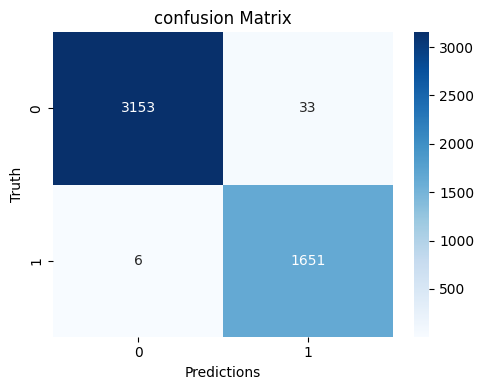

In [39]:
confusion_matrix=confusion_matrix(y_test,test_predictions)

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix,annot=True, fmt='d', cmap='Blues',)
plt.title("confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("Truth")

plt.tight_layout()
plt.show()

In [40]:
importance=best_estimator.feature_importances_
sorted_indices = np.argsort(importance)[::-1] 
features_names=preprocessor.get_feature_names_out()

top_n = 10
sorted_features_importance = [features_names[i] for i in sorted_indices[:top_n]]

print("Top Features by Importance:")
for i, feature in enumerate(sorted_features_importance):
    print(f"{i+1}. [{feature}] : {importance[sorted_indices[i]]}")

Top Features by Importance:
1. [cat__type_CASH_OUT] : 0.5810161232948303
2. [cat__type_DEBIT] : 0.28248924016952515
3. [num__newbalanceOrig] : 0.056306228041648865
4. [num__oldbalanceDest] : 0.03998177871108055
5. [num__newbalanceDest] : 0.01857464574277401
6. [num__oldbalanceOrg] : 0.012322529219090939
7. [num__amount] : 0.009309487417340279


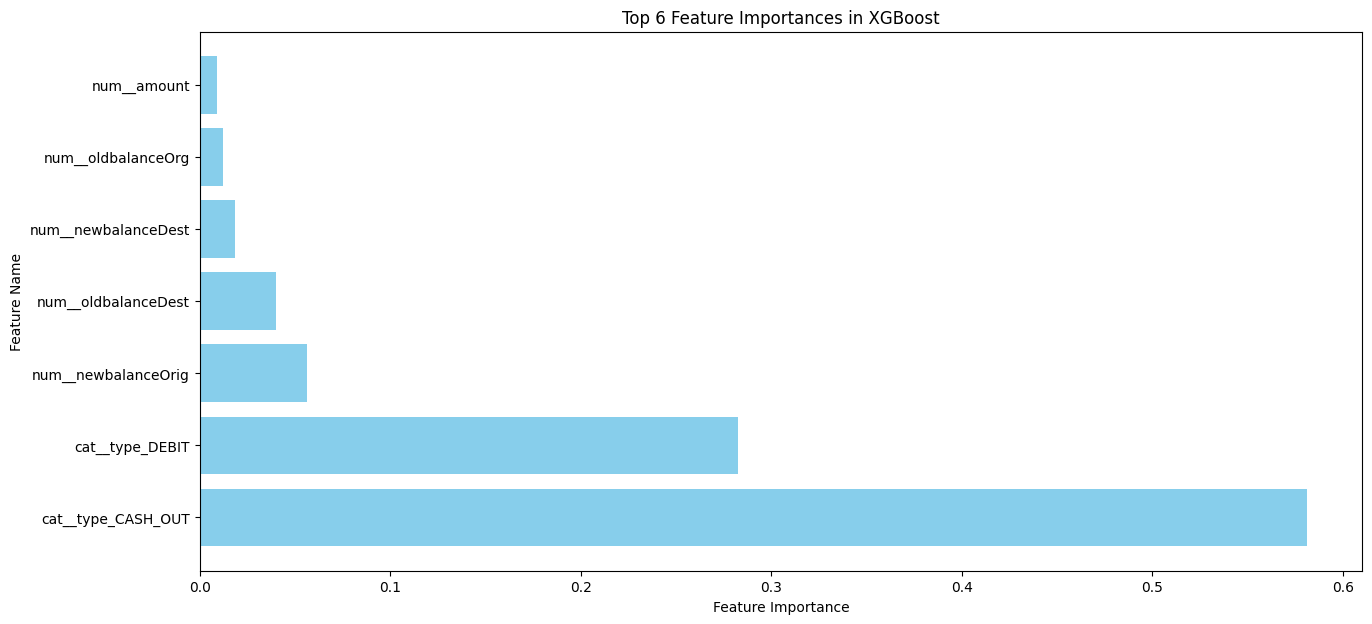

In [41]:
plt.figure(figsize=(15,7))
plt.barh(sorted_features_importance,importance[sorted_indices[:top_n]], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title("Top 6 Feature Importances in XGBoost")

plt.show()


# Exporting standardScaler infos

In [42]:
columns=num_features
standardScaler=preprocessor.named_transformers_['num']
data=[
    standardScaler.mean_,
    standardScaler.scale_
]
index=['mean','scale']

df_ss_info=pd.DataFrame(data,columns=columns,index=index)
df_ss_info

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
mean,6.274084e+05,1.097893e+06,6.108514e+05,8.981757e+05,1.244461e+06
scale,1.658503e+06,3.132229e+06,2.628934e+06,3.421207e+06,3.909139e+06


In [43]:
important_columns=['amount','oldbalanceOrg','newbalanceOrig']
df_ss_info=df_ss_info[important_columns]
df_ss_info

,amount,oldbalanceOrg,newbalanceOrig
mean,6.274084e+05,1.097893e+06,6.108514e+05
scale,1.658503e+06,3.132229e+06,2.628934e+06


In [44]:
df_ss_info.to_csv("../csv_files/credit_data_mean_scale.csv",index=True)

# Serialization

- serializing the model

In [45]:
jb.dump(best_estimator,"models/credit_fraud_detection_model.pkl")

['models/credit_fraud_detection_model.pkl']

- Serializing the column tansformer

In [46]:
jb.dump(preprocessor,"preprocessors/credit_fraud_data_preprocessor.pkl")

['preprocessors/credit_fraud_data_preprocessor.pkl']

In [47]:
x_train_processed.columns

Index(['num__amount', 'num__oldbalanceOrg', 'num__newbalanceOrig',
       'num__oldbalanceDest', 'num__newbalanceDest', 'cat__type_CASH_OUT',
       'cat__type_DEBIT', 'cat__type_PAYMENT', 'cat__type_TRANSFER'],
      dtype='object')